In [1]:
import attack_kernelbased
import attack_fgsm
import attack_df
import attack_jsma
import attack_gen
import dataloader
import spatial

import torch
import torch.nn as nn
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
X_train, X_test, y_train, y_test = dataloader.load(None)

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

/Users/sang-geon/Documents/UCI_BIASLab/kernel_adversarial/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(torch.Size([52500, 784]),
 torch.Size([17500, 784]),
 torch.Size([52500]),
 torch.Size([17500]))

In [3]:
X_test = X_test[:1000]
y_test = y_test[:1000]

In [4]:
D = 4000
model = onlinehd.OnlineHD(classes, features, dim=D)
model = model.fit(X_train, y_train, bootstrap=1.0, lr=0.035, epochs=2, one_pass_fit=False)

yhat_train = model(X_train)
yhat_test = model(X_test)

acc = (y_train == yhat_train).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(acc, acc_test)

tensor(0.9541) tensor(0.9530)


In [ ]:
with open('./onlinehd.pickle', 'bw') as f:
    pickle.dump(model, f)

In [4]:
with open('./onlinehd.pickle', 'br') as f:
    model = pickle.load(f)

In [5]:
model_cnn = DNNmodels.CNN()
model_cnn.load_state_dict(torch.load('./model_cnn.pt'))
model_cnn.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Kernel based attack

In [6]:
# with complex encoding (FHRR)
for e in np.linspace(0.01, 0.1, 10):#[0.01, 0.03, 0.07, 0.1]:
    st = time.time()
    X_test_noised = attack_kernelbased.genAdversarialNoise(model, X_test, y_test, e)
    print(time.time() - st)
    
    yhat_test = model(X_test_noised)
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [00:44<00:00, 22.51it/s]


45.204185009002686
0.01 0.00949000008404255 0.9309999942779541 0.968999981880188


100%|██████████| 1000/1000 [00:44<00:00, 22.54it/s]


45.038705825805664
0.020000000000000004 0.0189800001680851 0.9110000133514404 0.9660000205039978


100%|██████████| 1000/1000 [00:44<00:00, 22.49it/s]


45.136329889297485
0.030000000000000006 0.02846999652683735 0.871999979019165 0.9620000123977661


100%|██████████| 1000/1000 [00:44<00:00, 22.53it/s]


45.07034206390381
0.04000000000000001 0.0379600003361702 0.8230000138282776 0.9580000042915344


100%|██████████| 1000/1000 [00:44<00:00, 22.39it/s]


45.38427805900574
0.05000000000000001 0.04745000600814819 0.796999990940094 0.9520000219345093


100%|██████████| 1000/1000 [00:44<00:00, 22.44it/s]


45.21898794174194
0.06000000000000001 0.0569399930536747 0.7519999742507935 0.9490000009536743


100%|██████████| 1000/1000 [00:44<00:00, 22.41it/s]


45.41663217544556
0.07 0.066430002450943 0.6940000057220459 0.9419999718666077


100%|██████████| 1000/1000 [00:44<00:00, 22.70it/s]


44.76858997344971
0.08 0.0759200006723404 0.6230000257492065 0.9340000152587891


100%|██████████| 1000/1000 [00:44<00:00, 22.72it/s]


44.716556787490845
0.09000000000000001 0.08541001379489899 0.5630000233650208 0.9210000038146973


100%|██████████| 1000/1000 [00:44<00:00, 22.67it/s]


44.7816059589386
0.1 0.09490001201629639 0.4869999885559082 0.9049999713897705


## FGSM

### Normlized

100%|██████████| 1000/1000 [00:03<00:00, 265.35it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 3.7711121659999662 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 95.00%
mean of norm=0.01000000350177288


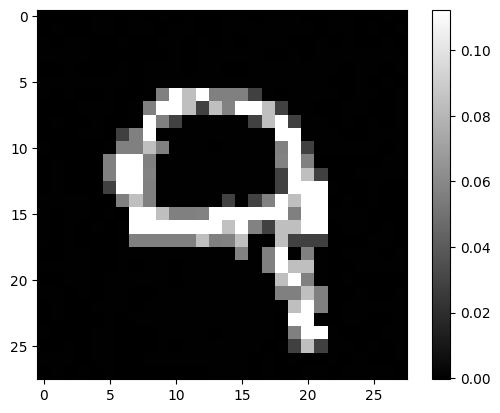

100%|██████████| 1000/1000 [00:03<00:00, 276.21it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 3.6265692919999992 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.70%
mean of norm=0.02000001259148121


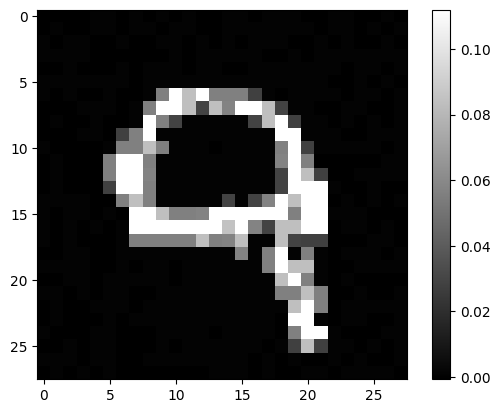

100%|██████████| 1000/1000 [00:03<00:00, 271.07it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 3.695551249999994 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.70%
mean of norm=0.029999997466802597


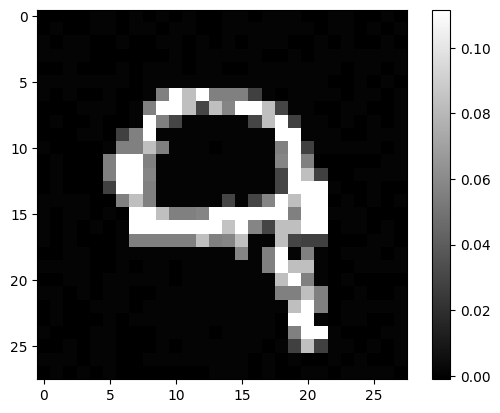

100%|██████████| 1000/1000 [00:03<00:00, 279.97it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 3.577799083000002 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.50%
mean of norm=0.04000002518296242


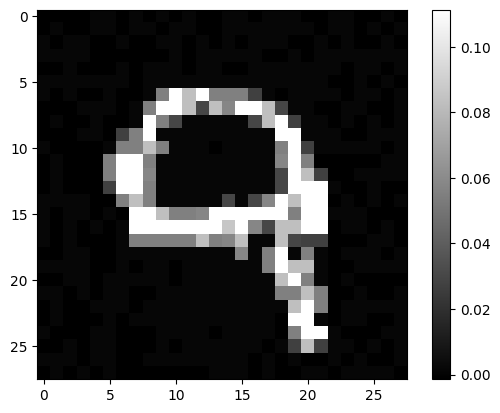

100%|██████████| 1000/1000 [00:03<00:00, 279.99it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 3.577710916000001 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.40%
mean of norm=0.04999999329447746


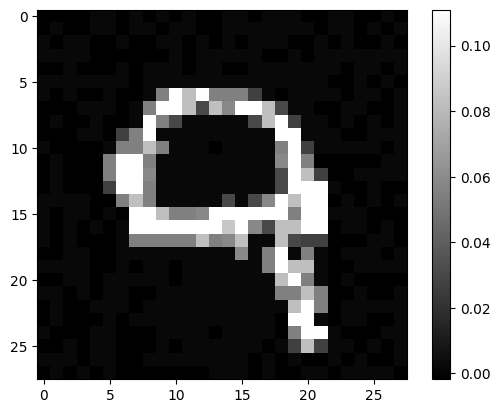

100%|██████████| 1000/1000 [00:03<00:00, 276.19it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 3.6269315420000225 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.40%
mean of norm=0.059999991208314896


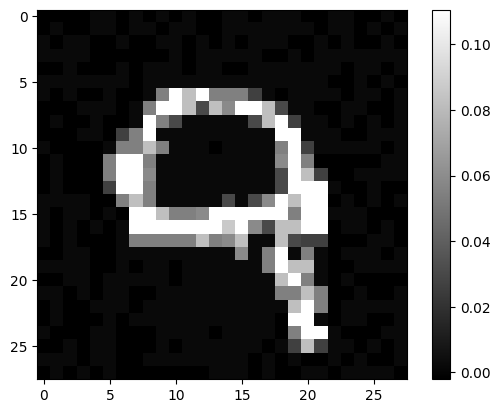

100%|██████████| 1000/1000 [00:03<00:00, 283.95it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 3.528108209000038 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.30%
mean of norm=0.06999997049570084


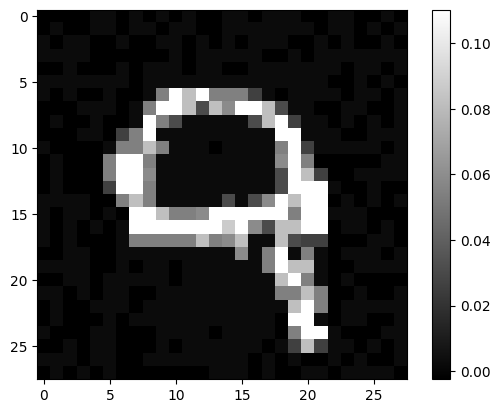

100%|██████████| 1000/1000 [00:03<00:00, 261.61it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 3.8288176659999635 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.20%
mean of norm=0.08000002801418304


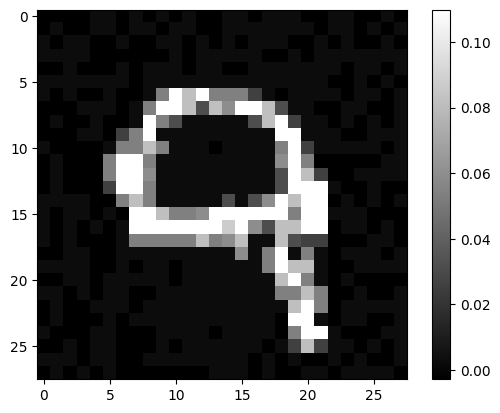

100%|██████████| 1000/1000 [00:03<00:00, 255.37it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 3.922397499999988 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.20%
mean of norm=0.09000000357627869


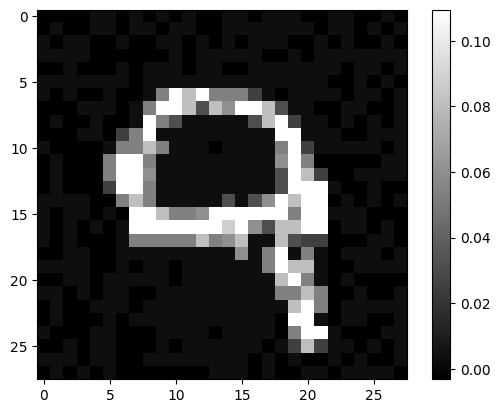

100%|██████████| 1000/1000 [00:03<00:00, 260.73it/s]



FGSM Attack with epsilon = 0.10000 | Elapsed time: 3.8418845420000025 seconds.
Accuracy: Before the attack -> 94.90%	|	After the attack -> 94.10%
mean of norm=0.09999994933605194


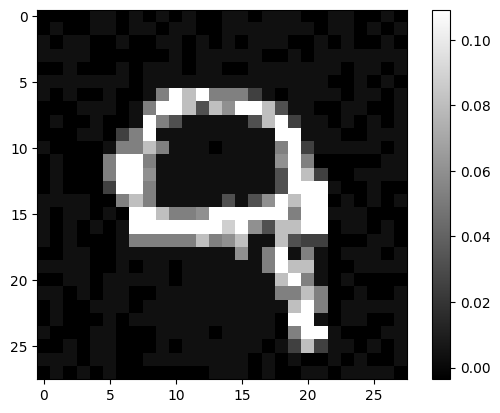

In [7]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
#criterion = nn.CosineEmbeddingLoss()
criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm.attack(
    model, X_train, X_test, y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu')

In [8]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

0.01 0.01000000350177288 0.949999988079071 0.9710000157356262
0.020000000000000004 0.02000001259148121 0.9470000267028809 0.968999981880188
0.030000000000000006 0.029999997466802597 0.9470000267028809 0.9670000076293945
0.04000000000000001 0.04000002518296242 0.9449999928474426 0.9670000076293945
0.05000000000000001 0.04999999329447746 0.9440000057220459 0.968999981880188
0.06000000000000001 0.059999991208314896 0.9440000057220459 0.968999981880188
0.07 0.06999997049570084 0.9430000185966492 0.968999981880188
0.08 0.08000002801418304 0.9419999718666077 0.9700000286102295
0.09000000000000001 0.09000000357627869 0.9419999718666077 0.9679999947547913
0.1 0.09999994933605194 0.9409999847412109 0.9679999947547913


### Not normalized

100%|██████████| 1000/1000 [00:03<00:00, 257.39it/s]


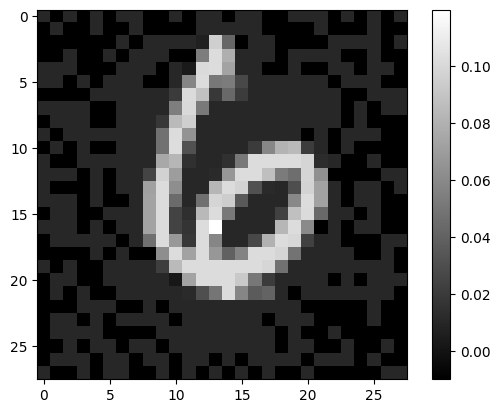


FGSM Attack with epsilon = 0.01000 | Elapsed time: 4.13 seconds.
Accuracy: Before the attack -> 93.20%	|	After the attack -> 86.90%


100%|██████████| 1000/1000 [00:04<00:00, 249.40it/s]


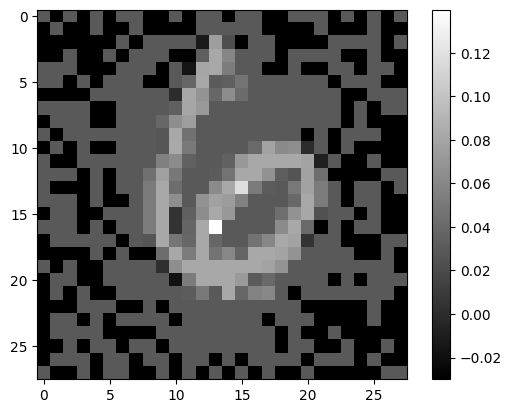


FGSM Attack with epsilon = 0.03000 | Elapsed time: 4.14 seconds.
Accuracy: Before the attack -> 93.20%	|	After the attack -> 15.10%


100%|██████████| 1000/1000 [00:03<00:00, 264.44it/s]


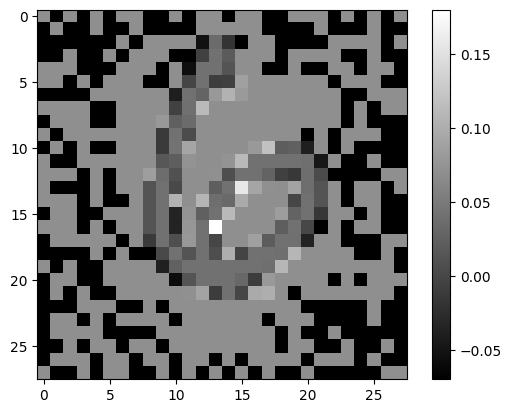


FGSM Attack with epsilon = 0.07000 | Elapsed time: 3.91 seconds.
Accuracy: Before the attack -> 93.20%	|	After the attack -> 2.20%


100%|██████████| 1000/1000 [00:03<00:00, 259.48it/s]


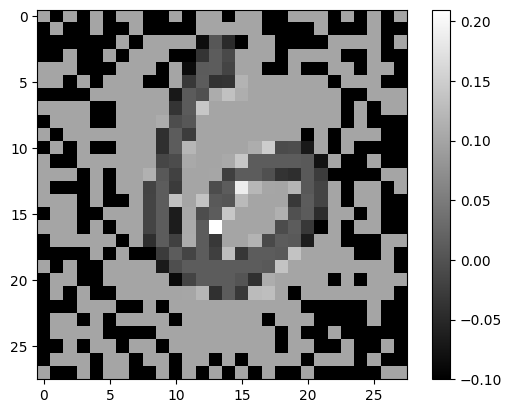


FGSM Attack with epsilon = 0.10000 | Elapsed time: 3.98 seconds.
Accuracy: Before the attack -> 93.20%	|	After the attack -> 4.40%


In [5]:
epsilons = torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
#criterion = nn.CosineEmbeddingLoss()
criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_sample, acc_results = attack_fgsm.attack(
    model, X_train, X_test, y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu')

## Deep Fool

In [9]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, 784)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=max_update)
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s]


104.83426785469055
0.01 0.005987776909023523 0.9430000185966492 0.9700000286102295


100%|██████████| 1000/1000 [01:41<00:00,  9.88it/s]


101.20681285858154
0.02 0.011975552886724472 0.9300000071525574 0.9679999947547913


100%|██████████| 1000/1000 [01:37<00:00, 10.28it/s]


97.31343102455139
0.03 0.017963329330086708 0.8949999809265137 0.9710000157356262


100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]


96.39359402656555
0.04 0.023951105773448944 0.8500000238418579 0.9660000205039978


100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


93.31465005874634
0.05 0.02993888594210148 0.824999988079071 0.9599999785423279


100%|██████████| 1000/1000 [01:27<00:00, 11.42it/s]


87.57505583763123
0.060000000000000005 0.035926662385463715 0.781000018119812 0.9589999914169312


100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


77.89133095741272
0.06999999999999999 0.0419144406914711 0.7200000286102295 0.9520000219345093


100%|██████████| 1000/1000 [01:09<00:00, 14.46it/s]


69.1617021560669
0.08 0.04790221154689789 0.6439999938011169 0.9440000057220459


100%|██████████| 1000/1000 [01:03<00:00, 15.83it/s]


63.15903878211975
0.09 0.05388999357819557 0.5870000123977661 0.9309999942779541


100%|██████████| 1000/1000 [00:58<00:00, 17.18it/s]


58.2257661819458
0.09999999999999999 0.05987777188420296 0.5230000019073486 0.9169999957084656


100%|██████████| 1000/1000 [00:54<00:00, 18.48it/s]


54.12847089767456
0.11 0.06586554646492004 0.49000000953674316 0.902999997138977


100%|██████████| 1000/1000 [00:50<00:00, 19.79it/s]


50.53886604309082
0.12 0.07185331732034683 0.4569999873638153 0.8880000114440918


100%|██████████| 1000/1000 [00:49<00:00, 20.39it/s]


49.04346299171448
0.13 0.07784109562635422 0.44200000166893005 0.8669999837875366


100%|██████████| 1000/1000 [00:48<00:00, 20.50it/s]


48.79382824897766
0.14 0.0838288813829422 0.4300000071525574 0.8500000238418579


100%|██████████| 1000/1000 [00:49<00:00, 20.25it/s]


49.375014305114746
0.15000000000000002 0.08981665223836899 0.4269999861717224 0.8399999737739563


100%|██████████| 1000/1000 [00:48<00:00, 20.48it/s]


48.81814503669739
0.16 0.09580442309379578 0.42500001192092896 0.8080000281333923


100%|██████████| 1000/1000 [00:48<00:00, 20.70it/s]


48.30518579483032
0.17 0.10179220885038376 0.42399999499320984 0.7789999842643738


100%|██████████| 1000/1000 [00:49<00:00, 20.16it/s]


49.59360671043396
0.18000000000000002 0.10777999460697174 0.42399999499320984 0.7559999823570251


100%|██████████| 1000/1000 [00:47<00:00, 20.99it/s]


47.65213322639465
0.19 0.11376775801181793 0.42399999499320984 0.7269999980926514


100%|██████████| 1000/1000 [00:45<00:00, 22.13it/s]


45.18810296058655
0.2 0.11975554376840591 0.42399999499320984 0.7080000042915344


In [10]:
X_te_cln = X_test.clone().reshape(-1, 1, 784)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=None)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test = model(X_test_noised.reshape(-1, 28*28))
yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [00:44<00:00, 22.29it/s]


None 0.1238793432712555 0.42399999499320984 0.7020000219345093


## JSMA

In [21]:
X_test.min(), X_test.max(), xadv.min(), xadv.max()

(tensor(0.), tensor(0.1970), tensor(0.), tensor(0.1970))

In [9]:
JSMA = attack_jsma.JacobianSaliencyMapAttack(model, gamma=0.01, num_classes=10)

xadv = torch.zeros(X_test.shape[0], 784)
xadv.targeted = False
xadv = JSMA.perturb(X_test, y_test)

# tmpy = model(X_test) # torch.zeros_like(y_test) - 1
# for i in tqdm.tqdm(range(xadv.shape[0])):
#     xadv[i] = JSMA.perturb(model, X_test[i].reshape(1, 784), y_test[i].reshape(1)) # y_test[i].reshape(1)

In [10]:
yhat_attack = model(xadv)
(y_test == yhat_attack).float().mean(), (xadv - X_test).norm(dim=-1).mean()

(tensor(1.), tensor(0.0844))

In [20]:
yhat_attack = model(xadv)
(y_test == yhat_attack).float().mean()

tensor(0.9810)

In [21]:
(xadv - X_test).norm(dim=-1).mean()

tensor(0.0145)

## Genetic Attack

In [12]:
alpha_lis = [0.001, 0.003, 0.007, 0.01]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    x_test_GA, _ = attack_gen.make_GA(model, delta, alpha, x_test_samp, y_test_samp)
    #model_accuracy_GA[n] = attack_gen.validate(model, x_test_GA.cpu(), y_test_samp)
    yhat_attack = model(x_test_GA)
    print((y_test == yhat_attack).float().mean(), (x_test_GA - X_test).norm(dim=-1).mean())

#model_accuracy_GA

Alpha : 0.001


100%|██████████| 1000/1000 [1:26:08<00:00,  5.17s/it]


tensor(0.9320) tensor(0.0889)
Alpha : 0.003


100%|██████████| 1000/1000 [1:30:06<00:00,  5.41s/it]


tensor(0.9020) tensor(0.1558)
Alpha : 0.007


100%|██████████| 1000/1000 [1:22:35<00:00,  4.96s/it]


tensor(0.9200) tensor(0.1427)
Alpha : 0.01


100%|██████████| 1000/1000 [1:24:29<00:00,  5.07s/it]


tensor(0.9210) tensor(0.1659)


In [11]:
alpha_lis = np.linspace(0.0001, 0.002, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen.make_GA(model, delta, alpha, x_test_samp, y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0001


100%|██████████| 1000/1000 [1:26:25<00:00,  5.19s/it]


5185.798140048981
0.0001 0.015685658901929855 0.9490000009536743 0.9710000157356262
Alpha : 0.0002


100%|██████████| 1000/1000 [1:32:53<00:00,  5.57s/it]


5573.073584794998
0.0002 0.03134988248348236 0.9470000267028809 0.9760000109672546
Alpha : 0.00030000000000000003


100%|██████████| 1000/1000 [1:53:29<00:00,  6.81s/it] 


6809.057289123535
0.00030000000000000003 0.04294669255614281 0.9480000138282776 0.968999981880188
Alpha : 0.0004


100%|██████████| 1000/1000 [1:50:03<00:00,  6.60s/it] 


6603.574810028076
0.0004 0.05046246200799942 0.949999988079071 0.9700000286102295
Alpha : 0.0005


100%|██████████| 1000/1000 [1:36:12<00:00,  5.77s/it]


5772.422894001007
0.0005 0.05541332811117172 0.9470000267028809 0.9739999771118164
Alpha : 0.0006000000000000001


100%|██████████| 1000/1000 [1:34:03<00:00,  5.64s/it]


5643.561096906662
0.0006000000000000001 0.06065293028950691 0.9419999718666077 0.9729999899864197
Alpha : 0.0007000000000000001


100%|██████████| 1000/1000 [1:45:13<00:00,  6.31s/it]


6313.785686969757
0.0007000000000000001 0.06667441129684448 0.9449999928474426 0.9679999947547913
Alpha : 0.0008


100%|██████████| 1000/1000 [1:59:30<00:00,  7.17s/it] 


7170.253109931946
0.0008 0.07290210574865341 0.9449999928474426 0.9700000286102295
Alpha : 0.0009000000000000001


100%|██████████| 1000/1000 [1:30:36<00:00,  5.44s/it]


5437.008726119995
0.0009000000000000001 0.07627139240503311 0.9459999799728394 0.9679999947547913
Alpha : 0.001


100%|██████████| 1000/1000 [1:41:34<00:00,  6.09s/it]


6094.508544921875
0.001 0.08149664103984833 0.9449999928474426 0.9649999737739563
Alpha : 0.0011


100%|██████████| 1000/1000 [1:28:13<00:00,  5.29s/it]


5293.370290994644
0.0011 0.08750703930854797 0.9390000104904175 0.9649999737739563
Alpha : 0.0012000000000000001


100%|██████████| 1000/1000 [1:23:28<00:00,  5.01s/it]


5008.486188173294
0.0012000000000000001 0.09144238382577896 0.9409999847412109 0.9620000123977661
Alpha : 0.0013000000000000002


100%|██████████| 1000/1000 [1:24:57<00:00,  5.10s/it]


5097.65371799469
0.0013000000000000002 0.09664884209632874 0.9369999766349792 0.9599999785423279
Alpha : 0.0014000000000000002


100%|██████████| 1000/1000 [1:23:52<00:00,  5.03s/it]


5032.087698936462
0.0014000000000000002 0.09876016527414322 0.9390000104904175 0.9679999947547913
Alpha : 0.0015


100%|██████████| 1000/1000 [1:30:10<00:00,  5.41s/it]


5410.872245788574
0.0015 0.10768848657608032 0.9309999942779541 0.9629999995231628
Alpha : 0.0016


 50%|████▉     | 497/1000 [46:59<47:33,  5.67s/it]  


KeyboardInterrupt: 